## Project 5: WAM News Prediction of  California's Gubernatorial 2021 Election

## Problem Statement:

WAM News is trying to develop an accurate model that predicts the gubernatorial election in California. Using the CCEC Dataset from Harvard University, we would like to build a classification model to accurately classify and predict California’s gubernatorial election preferences. The model will be evaluated based on accuracy, specificity, and recall with the goal of trying to get accuracy above null model.

In [2]:
# !pip install tensorflow

In [3]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline
# sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn import metrics
# keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import Recall
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

## Load Data

In [4]:
# read data
df=pd.read_csv('./data/2018_gov_clean1.csv', index_col=0)
df.head()

,dist,ownhome,pid3,gender,age,educ,race,faminc,marstat,newsint,approval_gov,ideo5,voted_gov
392782,19,Other,Democrat,Female,54,4-Year,White,50k - 60k,Single / Never Married,Most of the time,Strongly Approve,Liberal,1
392786,52,Rent,Democrat,Female,28,Some College,White,20k - 30k,Single / Never Married,Most of the time,Strongly Approve,Liberal,1
392800,49,Own,Other,Male,86,Post-Grad,White,120k - 150k,Widowed,Most of the time,Strongly Disapprove,Very Conservative,0
392832,36,Own,Republican,Male,80,Some College,White,20k - 30k,Widowed,Most of the time,Strongly Disapprove,Conservative,0
392860,36,Own,Independent,Male,83,4-Year,White,Prefer not to say,Married,Most of the time,Strongly Disapprove,Conservative,0


In [87]:
# check for null values
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3663 entries, 392782 to 452724
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   dist          3663 non-null   int64 
 1   ownhome       3663 non-null   object
 2   pid3          3663 non-null   object
 3   gender        3663 non-null   object
 4   age           3663 non-null   int64 
 5   educ          3663 non-null   object
 6   race          3663 non-null   object
 7   faminc        3663 non-null   object
 8   marstat       3663 non-null   object
 9   newsint       3663 non-null   object
 10  approval_gov  3663 non-null   object
 11  ideo5         3663 non-null   object
 12  voted_gov     3663 non-null   int64 
dtypes: int64(3), object(10)
memory usage: 400.6+ KB


In [5]:
# baseline accuracy
df.voted_gov.value_counts(normalize=True)

1    0.624352
0    0.375648
Name: voted_gov, dtype: float64

# Modeling

In [6]:
# set up X and y
X = df.drop(columns =['voted_gov'])
y = df['voted_gov']

In [7]:
# dummify X variable
X = pd.get_dummies(X, drop_first=True)

In [130]:
# checkout X shape
X.shape

(3663, 51)

In [131]:
# check if shape of X = y
assert X.shape[0]==y.shape[0]

### Null model

- For classification problems, we build our null model based on the most frequent value in the train data. We would use the shape of X_test to create array which will be predictions from the null model. 

In [55]:
# checkout X_test shape
X_test.shape

(916, 51)

In [56]:
# which one is the most frequent value?
y_train.value_counts(normalize=True)

1    0.624317
0    0.375683
Name: voted_gov, dtype: float64

In [59]:
# create an array of the most frequent value with number of rows equal to test data
# (this will be our null model predictions)
y_hat = np.zeros(916)
y_hat[:5]

array([0., 0., 0., 0., 0.])

In [60]:
# classification report for the null model
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.38      1.00      0.55       344
           1       0.00      0.00      0.00       572

    accuracy                           0.38       916
   macro avg       0.19      0.50      0.27       916
weighted avg       0.14      0.38      0.21       916



/Users/mekdeswassie/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mekdeswassie/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mekdeswassie/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Our null model accuracy is 38%.

### 1. Multinomial Naive Bayes

In [97]:
# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [98]:
# instantiate and fit NB
nb = MultinomialNB()
nb.fit(X_train, y_train)

MultinomialNB()

In [99]:
cross_val_score(nb, X_train, y_train, cv=5).mean()

0.8926047358834243

In [91]:
# make predictions 
y_pred_nb = nb.predict(X_test)

# save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_nb).ravel()

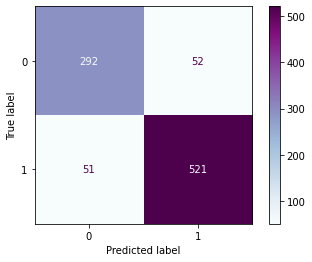

In [92]:
# plot a confusion matrix
plot_confusion_matrix(nb, X_test, y_test, cmap='BuPu', values_format='d');

In [93]:
# sensitivity and accuracy
accu = (tp+tn) / (tp+tn+fp+fn)
recall = tp/(tp+fn)
prec = tp/ (tp+fp)

print('Accuracy:', accu)
print('Recall:', recall)
print('Precision:', prec)

Accuracy: 0.8875545851528385
Recall: 0.9108391608391608
Precision: 0.9092495636998255


In [94]:
# accuracy on test Vs train data
print('Accuracy on train data:', nb.score(X_train, y_train))
print('Accuracy on test data:', nb.score(X_test, y_test))

Accuracy on train data: 0.896614488532945
Accuracy on test data: 0.8875545851528385


In [96]:
# classification report
print(classification_report(y_test, y_pred_nb))

              precision    recall  f1-score   support

           0       0.85      0.85      0.85       344
           1       0.91      0.91      0.91       572

    accuracy                           0.89       916
   macro avg       0.88      0.88      0.88       916
weighted avg       0.89      0.89      0.89       916



#### Multinomial Naive Bayes:
- 88.8% accuracy, 
- precision of 91% and 
- recall of 91%. 

It improved the null model accuracy of 38%.

Its accuracy on train data is 89.7% with test data accuracy of 88.8%. Hence, model is not overfit or underfit, its in the sweet spot.

### GridSearch

In [121]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [122]:
# scale data
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

In [136]:
# Function to create model, required for KerasClassifier
def create_model():
    # create model
    model = Sequential()
    model.add(Dense(32, input_shape=(51,), activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid')) 
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
# early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
# create model
model = KerasClassifier(build_fn=create_model, verbose=0)

# define the grid search parameters
params_grid = {
    'batch_size': [10, 20, 40, 60, 80, 100],
    'epochs': [10, 50, 100],
}

gs_deep = GridSearchCV(model, param_grid=params_grid, cv=3, n_jobs=-1)
gs_deep.fit(
    X_train_sc, 
    y_train, 
    callbacks=early_stop, 
    validation_data=(X_test_sc, y_test))
print(gs_deep.best_params_)
gs_deep.best_score_


Epoch 00014: early stopping
{'batch_size': 80, 'epochs': 100}


0.9260990619659424

In [142]:
# Make predictions 
preds_deep = gs_deep.predict(X_test_sc)

In [143]:
# classification report
print(classification_report(y_test, preds_deep))

              precision    recall  f1-score   support

           0       0.92      0.90      0.91       344
           1       0.94      0.95      0.95       572

    accuracy                           0.93       916
   macro avg       0.93      0.92      0.93       916
weighted avg       0.93      0.93      0.93       916



### 2. Neural Net Classification - Early stopping

In [45]:
# set a random seed
tf.random.set_seed(1234)

In [46]:
# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [47]:
# scale data
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

In [48]:
# create model with one hidden layer
model_nn1 = Sequential()
model_nn1.add(Dense(32, input_shape=(X_train_sc.shape[1],), activation='relu'))
model_nn1.add(Dense(1, activation='sigmoid'))

In [49]:
model_nn1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 32)                1664      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 1,697
Trainable params: 1,697
Non-trainable params: 0
_________________________________________________________________


In [50]:
# Compile it
model_nn1.compile(loss='bce', optimizer='adam', metrics=['Accuracy', 'Recall', 'Precision'])

In [51]:
# set early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

In [52]:
# fit model
history = model_nn1.fit(
    X_train_sc, y_train, 
    validation_data=(X_test_sc, y_test), 
    epochs=100, 
    callbacks=[early_stop], 
    verbose=2,
    batch_size=32
)

Epoch 1/100
86/86 - 1s - loss: 0.5085 - Accuracy: 0.7856 - recall: 0.9096 - precision: 0.7823 - val_loss: 0.3775 - val_Accuracy: 0.8821 - val_recall: 0.9458 - val_precision: 0.8754
Epoch 2/100
86/86 - 0s - loss: 0.2941 - Accuracy: 0.9090 - recall: 0.9481 - precision: 0.9099 - val_loss: 0.2637 - val_Accuracy: 0.9214 - val_recall: 0.9580 - val_precision: 0.9195
Epoch 3/100
86/86 - 0s - loss: 0.2176 - Accuracy: 0.9276 - recall: 0.9592 - precision: 0.9273 - val_loss: 0.2219 - val_Accuracy: 0.9181 - val_recall: 0.9493 - val_precision: 0.9219
Epoch 4/100
86/86 - 0s - loss: 0.1852 - Accuracy: 0.9319 - recall: 0.9580 - precision: 0.9346 - val_loss: 0.2062 - val_Accuracy: 0.9236 - val_recall: 0.9493 - val_precision: 0.9298
Epoch 5/100
86/86 - 0s - loss: 0.1689 - Accuracy: 0.9367 - recall: 0.9633 - precision: 0.9370 - val_loss: 0.1987 - val_Accuracy: 0.9247 - val_recall: 0.9423 - val_precision: 0.9374
Epoch 6/100
86/86 - 0s - loss: 0.1592 - Accuracy: 0.9367 - recall: 0.9574 - precision: 0.9421 -

In [53]:
# save history into a df
history_df = pd.DataFrame(history.history)
history_df.head()

,loss,Accuracy,recall,precision,val_loss,val_Accuracy,val_recall,val_precision
0,0.508476,0.785584,0.909621,0.782347,0.377455,0.882096,0.945804,0.875405
1,0.294056,0.908992,0.948105,0.909905,0.263650,0.921397,0.958042,0.919463
2,0.217605,0.927557,0.959184,0.927283,0.221949,0.918122,0.949301,0.921902
3,0.185162,0.931926,0.958017,0.934585,0.206239,0.923581,0.949301,0.929795
4,0.168870,0.936658,0.963265,0.937039,0.198711,0.924672,0.942308,0.937391


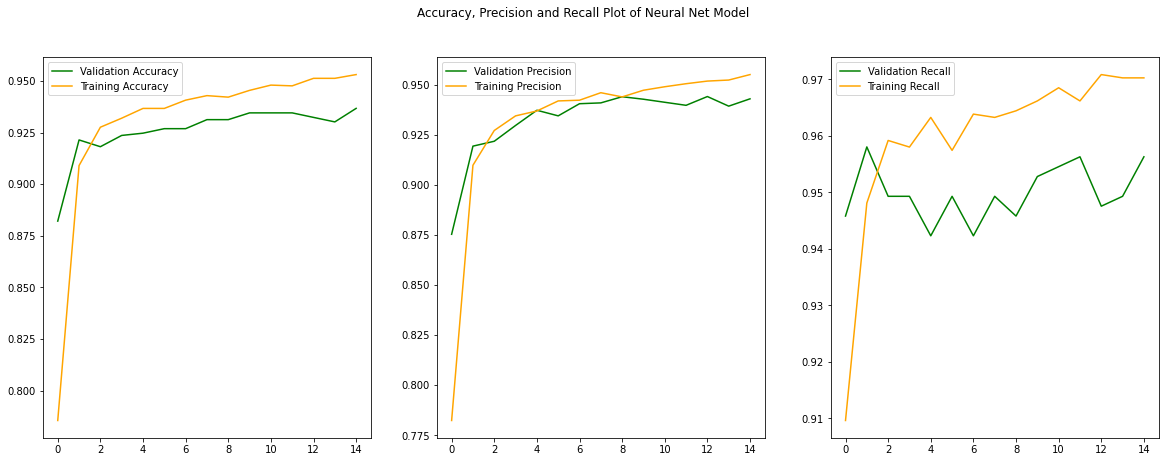

In [54]:
# subplots of accuracy, precision and recall
fig, (ax1, ax2, ax3) = plt.subplots(nrows = 1, ncols=3, figsize = (20, 7))
fig.suptitle('Accuracy, Precision and Recall Plot of Neural Net Model')

# axis 1
ax1.plot(history_df['val_Accuracy'], label='Validation Accuracy', color='green')
ax1.plot(history_df['Accuracy'], label='Training Accuracy', color='orange')
ax1.legend(loc="upper left")
# axis 2
ax2.plot(history_df['val_precision'], label='Validation Precision', color='green')
ax2.plot(history_df['precision'], label='Training Precision', color='orange')
ax2.legend(loc="upper left")
#axis3
ax3.plot(history_df['val_recall'], label='Validation Recall', color='green')
ax3.plot(history_df['recall'], label='Training Recall', color='orange')
ax3.legend(loc="upper right")

plt.legend();

The plots show that this model with one hidden layer and early stopping is slightly overfit. 

In [150]:
# evaluate model
model_nn1.evaluate(X_test_sc, y_test, verbose=2)

29/29 - 0s - loss: 0.1932 - Accuracy: 0.9367 - recall: 0.9563 - precision: 0.9431


[0.19315281510353088,
 0.9366812109947205,
 0.9562937021255493,
 0.9431034326553345]

In [151]:
# make predictions
y_pred_nn1=model_nn1.predict(X_test_sc)
y_pred_nn1[:10]

array([[0.7275185 ],
       [0.7263742 ],
       [0.00120929],
       [0.9989493 ],
       [0.47994626],
       [0.98545134],
       [0.9997022 ],
       [0.9999677 ],
       [0.01875579],
       [0.99897414]], dtype=float32)

In [152]:
# round predicted values
y_pred_nn1 =y_pred_nn1.round()
y_pred_nn1[:10]

array([[1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.]], dtype=float32)

In [153]:
# confusion matrix using Tensorflow
tf.math.confusion_matrix(
    y_test, y_pred_nn1
)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[311,  33],
       [ 25, 547]], dtype=int32)>

In [154]:
# classification report
print(classification_report(y_test, y_pred_nn1))

              precision    recall  f1-score   support

           0       0.93      0.90      0.91       344
           1       0.94      0.96      0.95       572

    accuracy                           0.94       916
   macro avg       0.93      0.93      0.93       916
weighted avg       0.94      0.94      0.94       916



On test data: 
- accuracy: 0.9108 
- recall: 0.8667 
- precision: 0.8925

On train data:
- accuracy: 0.9373 
- recall: 0.8888 
- precision: 0.9406

This model has an accuracy of 91% which improved the null model accuracy of 38%.  

### 3. Neural Net Classification - 2 hidden layers & dropout

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [62]:
# scale data
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

In [63]:
model_nn2 = Sequential()

In [64]:
# create model
model_nn2.add(Dense(32, input_shape=(X_train_sc.shape[1],), activation='relu'))
model_nn2.add(Dropout(0.2))
model_nn2.add(Dense(10, activation='relu'))
model_nn2.add(Dropout(0.2))
model_nn2.add(Dense(1, activation='sigmoid'))

In [65]:
# compile model
model_nn2.compile(loss='bce', optimizer ='adam', metrics = ['Accuracy', 'Recall', 'Precision'])

In [66]:
# fit model
history_2 = model_nn2.fit(
    X_train_sc,
    y_train,
    validation_data=(X_test_sc, y_test),
    epochs=100,
    verbose=0
)

In [67]:
# save history into a df
history_2_df = pd.DataFrame(history_2.history)
history_2_df.head()

,loss,Accuracy,recall,precision,val_loss,val_Accuracy,val_recall,val_precision
0,0.695043,0.586094,0.606997,0.692154,0.579397,0.751092,0.903846,0.749275
1,0.494738,0.783764,0.916035,0.777338,0.380851,0.852620,0.972028,0.823704
2,0.340514,0.856935,0.940525,0.847164,0.270758,0.901747,0.965035,0.887460
3,0.269882,0.898071,0.934111,0.905596,0.231794,0.919214,0.965035,0.910891
4,0.236185,0.912632,0.949854,0.913629,0.216868,0.930131,0.968531,0.923333


In [68]:
history_2_df['val_Accuracy'][5:]

5     0.927948
6     0.930131
7     0.927948
8     0.929039
9     0.926856
        ...   
95    0.920306
96    0.925764
97    0.923581
98    0.924672
99    0.921397
Name: val_Accuracy, Length: 95, dtype: float64

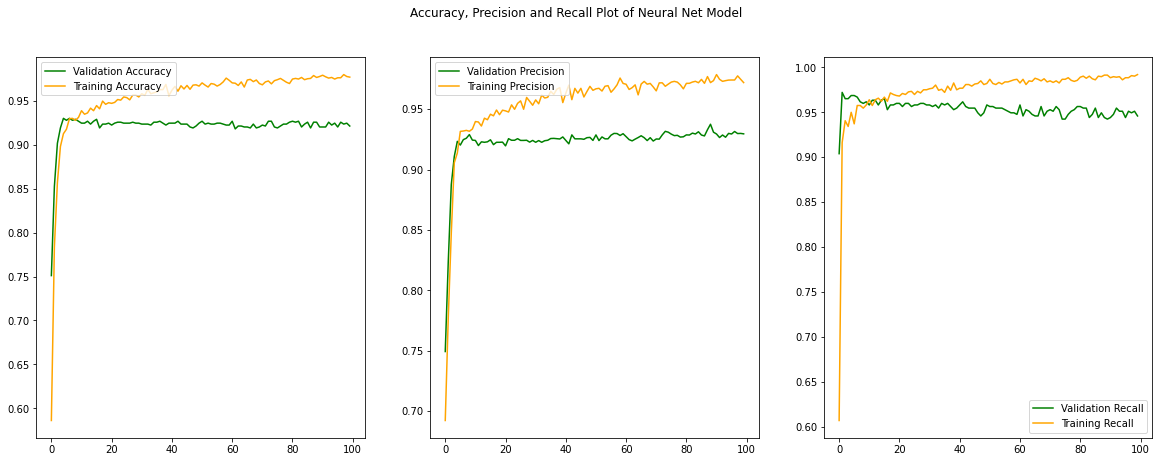

In [69]:
# subplots of accuracy, precision and recall
fig, (ax1, ax2, ax3) = plt.subplots(nrows = 1, ncols=3, figsize = (20, 7))
fig.suptitle('Accuracy, Precision and Recall Plot of Neural Net Model')

# axis 1 - accuracy
ax1.plot(history_2_df["val_Accuracy"], label='Validation Accuracy', color='green')
ax1.plot(history_2_df["Accuracy"], label='Training Accuracy', color='orange')
ax1.legend(loc="upper left")
# axis 2 - precision
ax2.plot(history_2_df['val_precision'], label='Validation Precision', color='green')
ax2.plot(history_2_df['precision'], label='Training Precision', color='orange')
ax2.legend(loc="upper left")
# axis3 - recall
ax3.plot(history_2_df['val_recall'], label='Validation Recall', color='green')
ax3.plot(history_2_df['recall'], label='Training Recall', color='orange')
ax3.legend(loc="upper right")

plt.legend();

In [70]:
# evaluate model
model_nn2.evaluate(X_test_sc, y_test, verbose=2)

29/29 - 0s - loss: 0.4582 - Accuracy: 0.9214 - recall: 0.9458 - precision: 0.9296


[0.45820382237434387,
 0.9213973879814148,
 0.9458041787147522,
 0.9295532703399658]

In [46]:
# make predictions
y_pred_nn2=model_nn2.predict(X_test_sc)
y_pred_nn2[:10]

array([[9.9999696e-01],
       [4.9172853e-05],
       [7.2009778e-01],
       [1.8903431e-01],
       [1.2260991e-01],
       [2.4028391e-02],
       [2.6009828e-02],
       [9.9999857e-01],
       [1.0962973e-05],
       [2.3484896e-09]], dtype=float32)

In [47]:
# round predicted values
y_pred_nn2 =y_pred_nn2.round()
y_pred_nn2[:10]

array([[1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.]], dtype=float32)

In [48]:
# confusion matrix using Tensorflow
tf.math.confusion_matrix(
    y_test, y_pred_nn2
)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[536,  38],
       [ 46, 299]], dtype=int32)>

In [49]:
# classification report
print(classification_report(y_test, y_pred_nn2))

              precision    recall  f1-score   support

           0       0.92      0.93      0.93       574
           1       0.89      0.87      0.88       345

    accuracy                           0.91       919
   macro avg       0.90      0.90      0.90       919
weighted avg       0.91      0.91      0.91       919



### 4. Neural Net Classification - Early stopping & dropout

In [105]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [106]:
# scale data
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

In [107]:
model_nn3 = Sequential()

In [108]:
# create model
model_nn3.add(Dense(32, input_shape=(X_train_sc.shape[1],), activation='relu'))
model_nn3.add(Dropout(0.1))
model_nn3.add(Dense(32, activation='relu'))

# model_nn3.add(Dropout(0.1))
# model_nn3.add(Dense(32, activation='relu'))

model_nn3.add(Dense(1, activation='sigmoid'))

# 'dropout': 0.1, 'epochs': 10, 'hidden_layers': 2, 'hidden_neurons': 32

In [109]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

In [110]:
# compile model
model_nn3.compile(loss='bce', optimizer ='adam', metrics = ['Accuracy', 'Recall', 'Precision'])

In [111]:
# fit model
history_3 = model_nn3.fit(
    X_train_sc,
    y_train,
    validation_data=(X_test_sc, y_test),
    epochs=100,
    callbacks=early_stop,
    verbose=0
)

Epoch 00015: early stopping


In [113]:
# save history into a df
history_3_df = pd.DataFrame(history_3.history)
history_3_df.head()

,loss,Accuracy,recall,precision,val_loss,val_Accuracy,val_recall,val_precision
0,0.488484,0.792501,0.918367,0.785536,0.340670,0.888646,0.945804,0.883987
1,0.266217,0.899891,0.944606,0.900000,0.247375,0.911572,0.961538,0.903120
2,0.210811,0.918821,0.949271,0.922902,0.224069,0.921397,0.963287,0.915282
3,0.180452,0.931198,0.954519,0.936499,0.217603,0.922489,0.959790,0.919598
4,0.170228,0.933746,0.961516,0.934278,0.218971,0.922489,0.940559,0.935652


In [114]:
history_3_df['val_Accuracy'][5:]

5     0.923581
6     0.923581
7     0.922489
8     0.930131
9     0.926856
10    0.929039
11    0.925764
12    0.927948
13    0.929039
14    0.926856
Name: val_Accuracy, dtype: float64

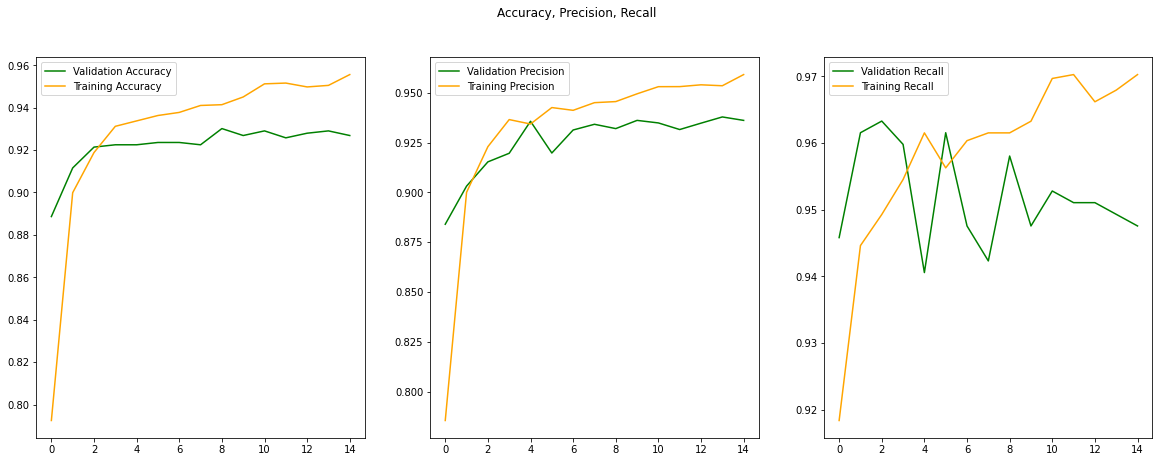

In [115]:
# subplots of accuracy, precision and recall
fig, (ax1, ax2, ax3) = plt.subplots(nrows = 1, ncols=3, figsize = (20, 7))
fig.suptitle('Accuracy, Precision, Recall')

# axis 1 - accuracy
ax1.plot(history_3_df["val_Accuracy"], label='Validation Accuracy', color='green')
ax1.plot(history_3_df["Accuracy"], label='Training Accuracy', color='orange')
ax1.legend(loc="upper left")
# axis 2 - precision
ax2.plot(history_3_df['val_precision'], label='Validation Precision', color='green')
ax2.plot(history_3_df['precision'], label='Training Precision', color='orange')
ax2.legend(loc="upper left")
# axis3 - recall
ax3.plot(history_3_df['val_recall'], label='Validation Recall', color='green')
ax3.plot(history_3_df['recall'], label='Training Recall', color='orange')
ax3.legend(loc="upper left")

plt.legend();

In [116]:
# evaluate model
model_nn3.evaluate(X_test_sc, y_test, verbose=2)

29/29 - 0s - loss: 0.2246 - Accuracy: 0.9269 - recall: 0.9476 - precision: 0.9361


[0.22459359467029572,
 0.9268559217453003,
 0.9475524425506592,
 0.936096727848053]

In [117]:
# make predictions
y_pred_nn3=model_nn3.predict(X_test_sc)
y_pred_nn3[:10]

array([[8.7984949e-01],
       [8.4997940e-01],
       [1.2658501e-05],
       [9.9940312e-01],
       [1.2734461e-01],
       [9.9416900e-01],
       [9.9977016e-01],
       [9.9998128e-01],
       [2.6096404e-03],
       [9.9922597e-01]], dtype=float32)

In [119]:
# round predicted values
y_pred_nn3 =y_pred_nn3.round()
y_pred_nn3[:10]

array([[1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.]], dtype=float32)

In [109]:
# confusion matrix using Tensorflow
tf.math.confusion_matrix(
    y_test, y_pred_nn3
)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[539,  35],
       [ 46, 299]], dtype=int32)>

In [120]:
# classification report
print(classification_report(y_test, y_pred_nn3))

              precision    recall  f1-score   support

           0       0.91      0.89      0.90       344
           1       0.94      0.95      0.94       572

    accuracy                           0.93       916
   macro avg       0.92      0.92      0.92       916
weighted avg       0.93      0.93      0.93       916



### GridSearch with nn

In [100]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [141]:
# X_train.shape

In [140]:
# ss = StandardScaler()
# X_train_sc = ss.fit_transform(X_train)
# X_test_sc = ss.transform(X_test)

In [103]:
# # Add an arugment of number of layers to the function (and loop through it) 
# def model_fn_deep(hidden_neurons, hidden_layers, dropout):
#   model = Sequential()
#   for layer in range(hidden_layers):
#     if layer == 0:
#       model.add(Dense(hidden_neurons, input_shape=(51,), activation='relu'))
#       model.add(Dropout(dropout))
#     else:
#       model.add(Dense(hidden_neurons, activation='relu'))
#       model.add(Dropout(dropout))

#   model.add(Dense(1, activation='sigmoid'))

#   model.compile(loss='bce', optimizer='adam', metrics =['Accuracy','Recall', 'Precision'])

#   return model

# nn_deep = KerasClassifier(build_fn=model_fn_deep, verbose=2)

In [137]:
# nn_params_deep = {
#     'hidden_neurons': [32, 64, 128],
#     'hidden_layers': [2, 3],
#     'dropout': [0.1, 0.2, 0.5],
#     'epochs': [10, 20, 30]
# }

# gs_deep = GridSearchCV(nn_deep, param_grid=nn_params_deep, cv=3, n_jobs=-1)
# gs_deep.fit(X_train_sc, y_train)
# print(gs_deep.best_params_)
# gs_deep.best_score_

In [42]:
# # Make predictions 
# preds_deep = gs_deep.predict(X_test_sc)

In [139]:
# # confusion matrix using Tensorflow
# tf.math.confusion_matrix(
#     y_test, preds_deep
# )

In [138]:
# # classification report
# print(classification_report(y_test, preds_deep))